In [1]:
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
START_DT = '2018-09-01'
END_DT = '2019-09-05'

In [0]:
dts = pd.date_range(START_DT, END_DT, freq='D')

In [0]:
TIME_LEN = len(dts)

In [5]:
TIME_LEN

370

In [0]:
PERIOD1 = 50  # day
PERIOD2 = 30  # day
F1 = 1 / PERIOD1
F2 = 1 / PERIOD2

In [0]:
feat1 = np.sin(2.0 * np.pi * F2 * np.arange(TIME_LEN)) \
        + np.cos(2.0 * np.pi * F1 *  np.arange(TIME_LEN)) \
        + 0.005*np.arange(TIME_LEN) \
        + 0.2*np.random.randn(TIME_LEN)

In [0]:
feat_scaler = MinMaxScaler((0, 0.1))

In [0]:
feat1 = feat_scaler.fit_transform(feat1.reshape(-1, 1)).flatten()

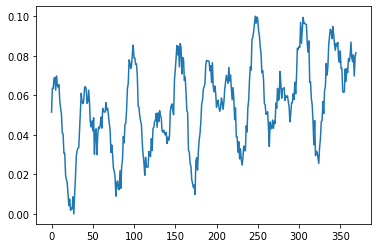

In [10]:
plt.plot(feat1)

In [76]:
feat1.max()

0.1

In [0]:
PERIOD3 = 40
F3 = 1 / PERIOD3

In [0]:
y = 0.6 * feat1 + 0.3 * feat1.max() * np.sin(2.0 * np.pi * F3 * np.arange(TIME_LEN)) + 0.1*feat1.max() *np.random.randn(TIME_LEN)+ 0.3 * feat1.max() * 0.01*np.arange(TIME_LEN)

In [0]:
y_scaler = MinMaxScaler((0, 0.1))

In [0]:
y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

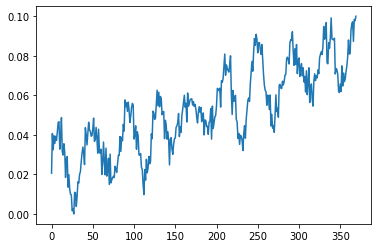

In [147]:
plt.plot(y)

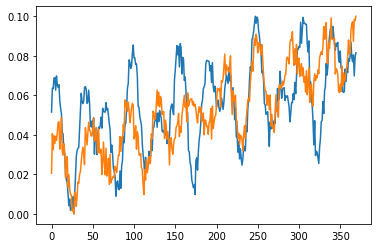

In [148]:
plt.plot(feat1)
plt.plot(y)

In [0]:
df = pd.DataFrame({
    'datetime': dts,
    'y': y,
    'feat1': feat1
})

In [0]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [0]:
df.set_index('datetime', inplace=True)

In [0]:
df['feat1_smooth'] = df['feat1'].rolling(10).mean()

In [0]:
df['y_smooth'] = df['y'].rolling(10).mean()

In [0]:
df.dropna(how='any', inplace=True)

In [0]:
ALPHA_D = 20

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df.y)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

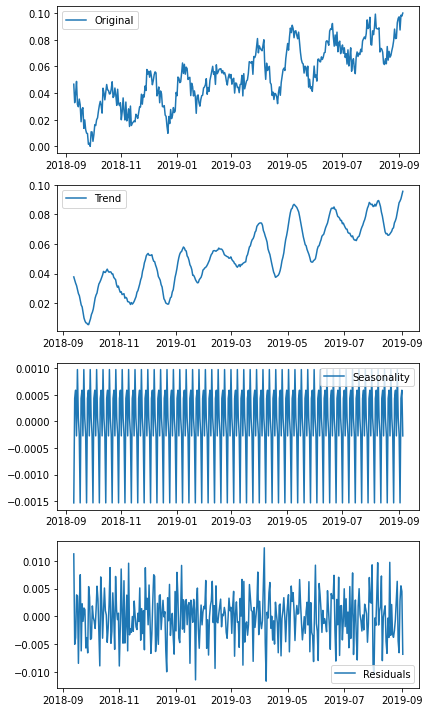

In [157]:
plt.figure(figsize=(6, 10))

plt.subplot(411)
plt.plot(df.y, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [0]:
df_train = df[df.index <= '2019-06']
df_test = df[df.index > '2019-06']

### y単体予測

In [159]:
sm.tsa.arma_order_select_ic(df_train.y_smooth, ic='aic', trend='nc')

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'aic':              0            1            2
 0          NaN -1220.280701 -1549.598430
 1 -2580.246698 -2740.154189 -2792.085880
 2 -2244.128730 -2933.428186 -2940.687621
 3 -2935.033755 -2935.166505 -2999.746142
 4 -2938.207632 -2952.085117 -2958.448139, 'aic_min_order': (3, 2)}

In [161]:
SARIMA_3_1_2 = sm.tsa.SARIMAX(
    df_train.y_smooth, order=(3, 1, 2),
    seasonal_order=(1, 1, 1, PERIOD3),
    enforce_stationarity = False,
    enforce_invertibility = False
).fit(method='bfgs')#, maxiter=3)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


         Current function value: -3.770265
         Iterations: 10
         Function evaluations: 98
         Gradient evaluations: 86


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


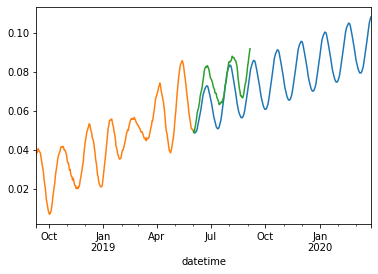

In [162]:
SARIMA_3_1_2.forecast(steps=300).plot()
df_train.y_smooth.plot()
df_test.y_smooth.plot()

### 外生変数feat追加

In [163]:
SARIMA_3_1_2_with_feat = sm.tsa.SARIMAX(
    endog=df_train.y_smooth,
    exog=df_train.feat1_smooth,
    order=(3, 1, 2),
    seasonal_order=(1, 1, 1, PERIOD3),
    enforce_stationarity = False,
    enforce_invertibility = False
).fit(method='bfgs')#, maxiter=3)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


         Current function value: -3.919348
         Iterations: 28
         Function evaluations: 77
         Gradient evaluations: 66


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [0]:
pred_with_feat = SARIMA_3_1_2_with_feat.forecast(steps=len(df_test), exog=df_test.feat1_smooth.to_numpy().reshape(-1, 1))

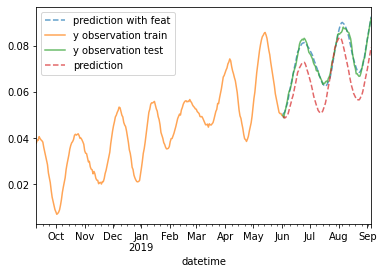

In [177]:
pred_with_feat.plot(linestyle='dashed', alpha=0.7, label='prediction with feat')
df_train.y_smooth.plot(alpha=0.7, label='y observation train')
df_test.y_smooth.plot(alpha=0.7, label='y observation test')
SARIMA_3_1_2.forecast(steps=len(df_test)).plot(linestyle='dashed', alpha=0.7, label='prediction')
plt.legend()